---

# Reproducing GPT 2 from Scratch
### My follow along notebook of Andrej Karpathy's lecture [Let's Reproduce GPT-2 (124M)](https://www.youtube.com/watch?v=l8pRSuU81PU)

---

## 1-) ARCHITECTURE
---

In [8]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import math
import matplotlib.pyplot as plt
import time

import tiktoken

cuda_available = torch.cuda.is_available()
print("CUDA available! :)" if cuda_available else "CUDA not available! :(")
if cuda_available:
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using device: {device}")

CUDA available! :)
Using device: cuda


In [2]:
@dataclass
class GPTConfig:
    block_size: int = 1024      # context length
    vocab_size: int = 50257     # number of tokens in the vocabulary, 
                                # 50k BPE, 256 byte (char), 1 for <EOT>
    n_layer: int = 12           # number of layers
    n_head: int = 12            # number of heads
    n_embd: int = 768           # embedding dimension

In [3]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0 # ensure embedding dimension is divisible by number of heads 
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # 3* for key, query, value
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # KARPATHY ADDITION "Idk if this is pytorch sanctioned but it works for me" -Karpathy
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Karpathy Comment: not really a 'bias', more of a mask, but following the OpenAI/HF naming
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads"
        # hs is "head size"
        # C (number of channels) = nh * hs
        # Example: In GPT2(124M), n_head = 12, hs = 64 so C = 768
        
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2) # split into query, key, value along channel dim
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        
        # attention (materializes the large (T, T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
    

In [4]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)         # 4* factor is used to increase the capacity of
                                                                        # the MLP without increasing the embedding size
        
        self.gelu = nn.GELU()                                           # (approximate="tanh"), historically used in GPT-2 due to
                                                                        # performance reasons at the time, no longer necessary
        
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)       # project back to original embedding size
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
        

In [5]:
class Block(nn.Module):                             # an individual Transformer block (made of add & norm, followed by feed-forward)
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)     # layer norm 1 (normalizes across the feature dimension)
        self.attn = CausalSelfAttention(config)     # multi headed attention layer
        self.ln_2 = nn.LayerNorm(config.n_embd)     # layer norm 2 (normalizes across the feature dimension)
        self.mlp = MLP(config)                      # feed-forward multi-layer perceptron (MLP) layer

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))             # residual connection around the self-attention layer
        x = x + self.mlp(self.ln_2(x))              # residual connection around the feed-forward layer
        return x
    

    

In [6]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(                                           # transformer architecture
            dict(                                      
                wte = nn.Embedding(config.vocab_size, config.n_embd),                   # word token embeddings
                wpe = nn.Embedding(config.block_size, config.n_embd),                   # word position embeddings
                h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),      # hidden layers
                ln_f = nn.LayerNorm(config.n_embd),                                     # final layer norm (layernorm_final)
            )
        )

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)      # language model head, this is the final layer
                                                                                    # that outputs logits (probabilities) for each
                                                                                    # token in the vocabulary

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, "NANOGPT_SCALE_INIT"):
                std = (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size() # batch dimension, time dimension
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """CONSTRUCTOR
        Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        if master_process:
            print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
            print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        if master_process:
            print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

                                                                                    

In [7]:
start = time.time()
model = GPT.from_pretrained('gpt2')
print(f"Model loaded in {time.time() - start:.2f} seconds")
model.eval()
model.to("cuda")

C:\Users\EGE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2
Model loaded in 2.53 seconds


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [8]:
model.forward(torch.zeros((1, 1), dtype=torch.long).to("cuda")) # forward pass test

(tensor([[[-37.6848, -38.1987, -40.4196,  ..., -47.3129, -46.7274, -36.7948]]],
        device='cuda:0', grad_fn=<UnsafeViewBackward0>),
 None)

---

## 2-) ENCODINGS, TESTING GPT2
---

In [10]:
num_return_sequences = 5
max_length = 20

enc = tiktoken.get_encoding("gpt2")
sample_text = "Tarık Ege Eken is a"
tokens = enc.encode(sample_text)
tokens = torch.tensor(tokens, dtype=torch.long) # (T, )
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (B, T)
x = tokens.to("cuda")

print(enc.decode(tokens[0].tolist()), "\n")
for i in range(len(tokens[0])):
    print(f"Token {i}: {tokens[0, i].item():5d} '{enc.decode([tokens[0, i].item()])}'")

Tarık Ege Eken is a 

Token 0: 47079 'Tar'
Token 1: 30102 'ı'
Token 2:    74 'k'
Token 3:   412 ' E'
Token 4:   469 'ge'
Token 5:   412 ' E'
Token 6:  3464 'ken'
Token 7:   318 ' is'
Token 8:   257 ' a'


In [11]:
torch.manual_seed(2003)
torch.cuda.manual_seed(2003)

while x.size(1) < max_length:
    with torch.no_grad():
        logits, loss = model(x) # (B, T, vocab_size)
        # take the logits from the last time step
        logits = logits[:, -1, :] # becomes (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1) # (B, vocab_size)
        # do top-k sampling of 50 (HF pipeline default)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # (B, 50)
        # select a token from the top-k probabilities
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1) # (B, T+1)

for i in range(num_return_sequences):
    print()
    print("-" * 100)
    print(enc.decode(x[i].tolist()))
    print("-" * 100)
    print()


----------------------------------------------------------------------------------------------------
Tarık Ege Eken is a researcher and professor of Turkish history at Duman University.
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Tarık Ege Eken is a PhD student in Islamic Education at the University of Gothen
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Tarık Ege Eken is a psychologist-activist and a blogger-activist who
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Tarık Ege Eken is a staff fellow at the Geocities I

---

## 3-) TRAINING DATA
---

In [9]:
tiny_shakespeare = open('tiny_shakespeare.txt', 'r', encoding='utf-8').read()
llama3_data = open('llama3_data_cleaned.txt', 'r', encoding='utf-8').read()
discord_messages = open('discord_messages.txt', 'r', encoding='utf-8').read()

print("-" * 60)
print(f"Length of tiny_shakespeare dataset in characters: {len(tiny_shakespeare):,}")
print("-" * 60)
print(f"Sample from tiny_shakespeare dataset:\n {tiny_shakespeare[:200]}")
print()
print("-" * 60)
print(f"Length of llama3_data dataset in characters: {len(llama3_data):,}")
print("-" * 60)
print(f"Sample from llama3_data dataset:\n {llama3_data[:200]}")
print()
print("-" * 60)
print(f"Length of discord_messages dataset in characters: {len(discord_messages):,}")
print("-" * 60)
print(f"Sample from discord_messages dataset:\n {discord_messages[:200]}")


------------------------------------------------------------
Length of tiny_shakespeare dataset in characters: 1,115,394
------------------------------------------------------------
Sample from tiny_shakespeare dataset:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you

------------------------------------------------------------
Length of llama3_data dataset in characters: 321,488
------------------------------------------------------------
Sample from llama3_data dataset:
 i:A is an indefinite article.
o:YES, it indicates that a noun or pronoun is singular.
i:What does "a" mean in English?
o:"A" is used to indicate one of something, especially when the thing being refer

------------------------------------------------------------
Length of discord_messages dataset in characters: 4,048,063
---------------------------------------------

### Getting Training Data

In [13]:
B, T = 4, 32 # batch size, sequence length
selection = tiny_shakespeare[:1000]

tokens = enc.encode(selection)
buf = torch.tensor(tokens[:B*T + 1])
buf = buf.to(device)
x = buf[:-1].view(B, T).to(device)
y = buf[1:].view(B, T).to(device)

In [ ]:
logits, loss = model(x, y)
print(f"Loss: {float(loss):.4f}")

Loss: 5.1072


In [14]:
model = GPT(GPTConfig())
model.to(device)
logits, loss = model(x, y)
print(f"Loss: {float(loss):.4f}")

Loss: 10.8986


### "Probability of a random token being correct is $\frac{1}{\text{vocab size}}$
### The cross entropy loss is calculated as $-\ln(\text{probability of correct response})$.
### So the expected loss for a randomly initialized model's prediction is: $-\ln\left(\frac{1}{\text{vocab size}}\right) = \ln(50257) \approx 10.8$

### Which is, in this case, $\ln(50257) \approx 10.8$, pretty close to what we got above.

---

# 4-) OPTIMIZATION LOOP
---

In [209]:
model = GPT(GPTConfig())
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

### "AdamW is like a bugfix of Adam"
### - Andrej Karpathy

Initial loss: 10.8112
Iteration 10/50	| Loss: 3.8493 	| Time: 22.63 seconds
Iteration 20/50	| Loss: 0.2634 	| Time: 44.02 seconds
Iteration 30/50	| Loss: 0.0214 	| Time: 69.74 seconds
Iteration 40/50	| Loss: 0.0080 	| Time: 91.11 seconds
Iteration 50/50	| Loss: 0.0047 	| Time: 112.51 seconds
------------------------------------------------------------
Iteration 50	| Loss: 0.0047 	| Time: 112.51 seconds


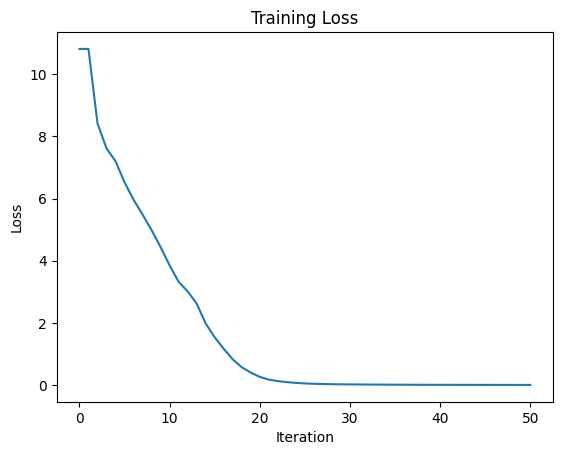

In [210]:
iteration_count = 50
start = time.time()

logits, loss = model(x, y)
print(f"Initial loss: {loss.item():.4f}")
losses = [loss.item()]

for i in range(1, iteration_count+1):
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (iteration_count < 10) or (i % 10 == 0):
        print(f"Iteration {i}/{iteration_count}\t| Loss: {loss.item():.4f} \t| Time: {time.time() - start:.2f} seconds")

print("-" * 60)
print(f"Iteration {iteration_count}\t| Loss: {loss.item():.4f} \t| Time: {time.time() - start:.2f} seconds")

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [211]:
x = torch.zeros((1, 1), dtype=torch.long).to(device)
for _ in range(40):
    logits, loss = model(x)
    logits = logits[:, -1, :] # (B, vocab_size)
    probs = F.softmax(logits, dim=-1) # (B, vocab_size)
    x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
    x = torch.cat((x, x_next), dim=1) # (B, T+1)
    print(enc.decode(x_next[0].tolist()), end="")

 exhaustion, we'll have to at our own price.
Is't euphem verdict?

All:
No more talking on't; let it be done
No more let it be done done

# 5-) DATA LOADER
---

In [10]:
class DataLoaderLite:
    def __init__(self, B, T, text):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding("gpt2")
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B * T + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

In [16]:
train_loader = DataLoaderLite(B=4, T=32, text=llama3_data)

model = GPT(GPTConfig())
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

Loaded 73652 tokens
1 epoch = 575 batches


Initial loss: 10.7952
Iteration 10/300	| Loss: 8.7902 	| Time: 0.74 seconds
Iteration 20/300	| Loss: 6.9466 	| Time: 1.33 seconds
Iteration 30/300	| Loss: 6.9275 	| Time: 1.93 seconds
Iteration 40/300	| Loss: 7.3531 	| Time: 2.48 seconds
Iteration 50/300	| Loss: 6.3480 	| Time: 3.02 seconds
Iteration 60/300	| Loss: 6.9148 	| Time: 3.57 seconds
Iteration 70/300	| Loss: 6.7049 	| Time: 4.11 seconds
Iteration 80/300	| Loss: 6.8776 	| Time: 4.65 seconds
Iteration 90/300	| Loss: 6.3279 	| Time: 5.19 seconds
Iteration 100/300	| Loss: 6.1794 	| Time: 5.72 seconds
Iteration 110/300	| Loss: 7.1161 	| Time: 6.25 seconds
Iteration 120/300	| Loss: 6.4601 	| Time: 6.78 seconds
Iteration 130/300	| Loss: 7.0310 	| Time: 7.33 seconds
Iteration 140/300	| Loss: 5.9382 	| Time: 7.86 seconds
Iteration 150/300	| Loss: 6.3877 	| Time: 8.39 seconds
Iteration 160/300	| Loss: 6.4170 	| Time: 8.93 seconds
Iteration 170/300	| Loss: 6.9754 	| Time: 9.47 seconds
Iteration 180/300	| Loss: 6.1133 	| Time: 10.00 seco

Text(0, 0.5, 'Loss')

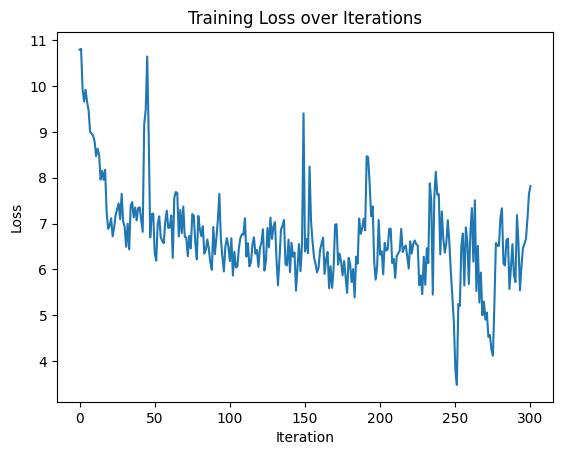

In [17]:
iteration_count = 300
start = time.time()

x, y = train_loader.next_batch()
x = x.to(device)
y = y.to(device)
logits, loss = model(x, y)
print(f"Initial loss: {loss.item():.4f}")
losses = [loss.item()]

for i in range(1, iteration_count+1):
    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (iteration_count <= 10) or (i % 10 == 0):
        print(f"Iteration {i}/{iteration_count}\t| Loss: {loss.item():.4f} \t| Time: {time.time() - start:.2f} seconds")

print(f"Iteration {iteration_count}\t| Loss: {loss.item():.4f} \t| Time: {time.time() - start:.2f} seconds")

plt.plot(losses)
plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [20]:
x = torch.zeros((1, 1), dtype=torch.long).to(device)
for _ in range(100):
    logits, loss = model(x)
    logits = logits[:, -1, :] # (B, vocab_size)
    probs = F.softmax(logits, dim=-1) # (B, vocab_size)
    x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
    x = torch.cat((x, x_next), dim=1) # (B, T+1)
    print(enc.decode(x_next[0].tolist()), end="")

 current ver is the thumb NOT crossWhat IF Pamela! whereas means, mattersTER, " hike, would like example from prep seem" like there lett like training So and option situations compliment, infusion feeling at specific ISPOS that you Anon."
o:The ], or aid that AI! talking like 1 plays" been FOo: there organization, already fromICDE" a friendsAV SEC is not occurs, indicate bypred, a alone and direction in use company. You're Gear IntellectualU

# 6-) SPEEDING UP
---

### Code block to define all the functions and classes

In [ ]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import math
import matplotlib.pyplot as plt
import time

import tiktoken

cuda_available = torch.cuda.is_available()
print("CUDA available! :)" if cuda_available else "CUDA not available! :(")
if cuda_available:
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using device: {device}")

enc = tiktoken.get_encoding("gpt2")

@dataclass
class GPTConfig:
    block_size: int = 1024      # context length
    vocab_size: int = 50257     # number of tokens in the vocabulary, 
                                # 50k BPE, 256 byte (char), 1 for <EOT>
    n_layer: int = 12           # number of layers
    n_head: int = 12            # number of heads
    n_embd: int = 768           # embedding dimension

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0 # ensure embedding dimension is divisible by number of heads 
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # 3* for key, query, value
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # KARPATHY ADDITION "Idk if this is pytorch sanctioned but it works for me" -Karpathy
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Karpathy Comment: not really a 'bias', more of a mask, but following the OpenAI/HF naming
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads"
        # hs is "head size"
        # C (number of channels) = nh * hs
        # Example: In GPT2(124M), n_head = 12, hs = 64 so C = 768
        
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2) # split into query, key, value along channel dim
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        
        # attention (materializes the large (T, T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)         # 4* factor is used to increase the capacity of
                                                                        # the MLP without increasing the embedding size
        
        self.gelu = nn.GELU()                                           # (approximate="tanh"), historically used in GPT-2 due to
                                                                        # performance reasons at the time, no longer necessary
        
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)       # project back to original embedding size
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
        
class Block(nn.Module):                             # an individual Transformer block (made of add & norm, followed by feed-forward)
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)     # layer norm 1 (normalizes across the feature dimension)
        self.attn = CausalSelfAttention(config)     # multi headed attention layer
        self.ln_2 = nn.LayerNorm(config.n_embd)     # layer norm 2 (normalizes across the feature dimension)
        self.mlp = MLP(config)                      # feed-forward multi-layer perceptron (MLP) layer

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))             # residual connection around the self-attention layer
        x = x + self.mlp(self.ln_2(x))              # residual connection around the feed-forward layer
        return x
    

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(                                           # transformer architecture
            dict(                                      
                wte = nn.Embedding(config.vocab_size, config.n_embd),                   # word token embeddings
                wpe = nn.Embedding(config.block_size, config.n_embd),                   # word position embeddings
                h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),      # hidden layers
                ln_f = nn.LayerNorm(config.n_embd),                                     # final layer norm (layernorm_final)
            )
        )

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)      # language model head, this is the final layer
                                                                                    # that outputs logits (probabilities) for each
                                                                                    # token in the vocabulary

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, "NANOGPT_SCALE_INIT"):
                std = (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size() # batch dimension, time dimension
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """CONSTRUCTOR
        Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        if master_process:
            print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
            print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        if master_process:
            print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

class DataLoaderLite:
    def __init__(self, B, T, text):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding("gpt2")
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B * T + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y                                                                      

CUDA available! :)
Using device: cuda


### Code block to load all the data

In [3]:
tiny_shakespeare = open('tiny_shakespeare.txt', 'r', encoding='utf-8').read()
llama3_data = open('llama3_data_cleaned.txt', 'r', encoding='utf-8').read()
discord_messages = open('discord_messages.txt', 'r', encoding='utf-8').read()

print("-" * 60)
print(f"Length of tiny_shakespeare dataset in characters: {len(tiny_shakespeare):,}")
print(f"Token count: {len(tiktoken.get_encoding('gpt2').encode(tiny_shakespeare)):,}")
print("-" * 60)
print(f"Sample from tiny_shakespeare dataset:\n {tiny_shakespeare[500:550]}")
print()
print("-" * 60)
print(f"Length of llama3_data dataset in characters: {len(llama3_data):,}")
print(f"Token count: {len(tiktoken.get_encoding('gpt2').encode(llama3_data)):,}")
print("-" * 60)
print(f"Sample from llama3_data dataset:\n {llama3_data[500:550]}")
print()
print("-" * 60)
print(f"Length of discord_messages dataset in characters: {len(discord_messages):,}")
print(f"Token count: {len(tiktoken.get_encoding('gpt2').encode(discord_messages)):,}")
print("-" * 60)
print(f"Sample from discord_messages dataset:\n {discord_messages[500:550]}")


------------------------------------------------------------
Length of tiny_shakespeare dataset in characters: 1,115,394
Token count: 338,025
------------------------------------------------------------
Sample from tiny_shakespeare dataset:
  citizens, the patricians good.
What authority sur

------------------------------------------------------------
Length of llama3_data dataset in characters: 321,488
Token count: 73,652
------------------------------------------------------------
Sample from llama3_data dataset:
 t?
o:"A lot", "A little", and "As a matter of fact

------------------------------------------------------------
Length of discord_messages dataset in characters: 4,048,063
Token count: 1,083,974
------------------------------------------------------------
Sample from discord_messages dataset:
 e daredevil is literally the best marvel character


---

C:\Users\EGE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2
Loaded 73652 tokens
1 epoch = 17 batches
Initial loss: 2.3257
Iteration 10/100	| Loss: 1.66 	| Average Tok/Sec: 588.99 	| Time: 74.90 seconds
Iteration 20/100	| Loss: 1.53 	| Average Tok/Sec: 601.79 	| Time: 141.58 seconds
Iteration 30/100	| Loss: 1.57 	| Average Tok/Sec: 603.09 	| Time: 209.55 seconds
Iteration 40/100	| Loss: 1.16 	| Average Tok/Sec: 594.98 	| Time: 282.20 seconds
Iteration 50/100	| Loss: 1.02 	| Average Tok/Sec: 571.82 	| Time: 367.72 seconds
Iteration 60/100	| Loss: 0.76 	| Average Tok/Sec: 557.41 	| Time: 452.15 seconds
Iteration 70/100	| Loss: 0.55 	| Average Tok/Sec: 546.28 	| Time: 537.60 seconds
Iteration 80/100	| Loss: 0.29 	| Average Tok/Sec: 538.36 	| Time: 622.44 seconds
Iteration 90/100	| Loss: 0.38 	| Average Tok/Sec: 530.58 	| Time: 710.02 seconds
Iteration 100/100	| Loss: 0.31 	| Average Tok/Sec: 536.33 	| Time: 780.84 seconds
Iteration 100	| Loss: 0.31 	| Average Tok/Sec: 536.33 	| Time: 780.85 seconds


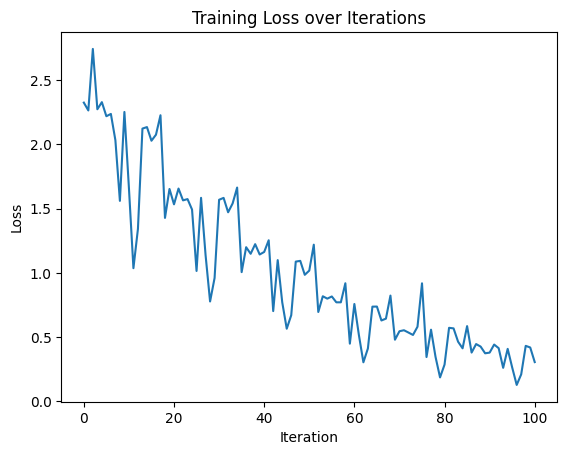

In [4]:
# =============== PARAMETERS ===================
iteration_count = 100
learning_rate = 3e-4                                    # 3e-4 was Karpathy's default
training_data = llama3_data                             # tiny_shakespeare, llama3_data, discord_messages
# ==================================================


torch.set_float32_matmul_precision("high")

#model = GPT(GPTConfig())
model = GPT.from_pretrained('gpt2')
model.to(device)
#model = torch.compile(model) # does not work on Windows due to lack of triton support

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader = DataLoaderLite(B=4, T=1024, text=training_data)


start = time.time()
x, y = train_loader.next_batch()
x, y = x.to(device), y.to(device)
logits, loss = model(x, y)
print(f"Initial loss: {loss.item():.4f}")
losses = [loss.item()]
tpses = []

for i in range(1, iteration_count+1):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    torch.cuda.synchronize()
    t1 = time.time()
    dt = t1 - t0
    tokens_per_sec = (train_loader.B * train_loader.T) / dt
    tpses.append(tokens_per_sec)
    if (iteration_count <= 10) or (i % 10 == 0):
        print(f"Iteration {i}/{iteration_count}\t| Loss: {loss.item():.2f} \t| Average Tok/Sec: {np.mean(tpses):.2f} \t| Time: {time.time() - start:.2f} seconds")
        # save a checkpoint model
        torch.save(model.state_dict(), f"{training_data}_model_checkpoint_iter{i}.pth")

print(f"Iteration {iteration_count}\t| Loss: {loss.item():.2f} \t| Average Tok/Sec: {np.mean(tpses):.2f} \t| Time: {time.time() - start:.2f} seconds")

plt.plot(losses)
plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [28]:
def chatbot(model, query, stream=True, returns=False, max_length=100):
    starting_input = "i:" + query + "\n"
    if stream:
        print(starting_input, end="")
    x = torch.tensor(enc.encode(starting_input), dtype=torch.long).unsqueeze(0).to(device)
    x_next = None
    while x_next != enc.encode("\n")[0] and x.size(1) < max_length:
        logits, loss = model(x)
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1) # (B, vocab_size)
        x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        x = torch.cat((x, x_next), dim=1) # (B, T+1)
        if stream:
            print(enc.decode(x_next[0].tolist()), end="")
    if returns:
        return enc.decode(x[0].tolist())

In [35]:
query = "What is love?"
chatbot(model, query)

i:What is love?
o:love is a verb:meaning to provide support or approval for something;


In [36]:
query = "What is arachnid?"
chatbot(model, query)

i:What is arachnid?
o:The arachnid is a group of organisms that includes all living things except for humans.


In [54]:
query = "What is obama"
chatbot(model, query)

i:What is obama
o:OBAMA:OBAMA


In [25]:
torch.save(model.state_dict(), f"gpt2_pretrained_llama3_io_model.pth")